In [1]:
import numpy as np
import pandas as pd
import pyaldata as pyal
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

from util import prep

In [3]:
# session = "M052_2025_01_27_15_00"
# session = "M047_2024_11_22_11_00"
session = "M051_2025_02_09_16_45"

animal = session[0:4]
data_dir = 'C:/Users/Cecilia/data/raw'
filename = session + '_pyaldata.mat'
# df = prep.convert_mat_to_df(data_dir + '/' + animal + '/' + session + '/' + filename) # convert mat file to pandas dataframe
# df = prep.prep_general(df) # run general preprocessing

In [ ]:
def load_BCI_log(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    if not lines:
        return pd.DataFrame(columns=["timestamp", "loglevel", "message"])

    # Get the prefix from the first line by splitting based on ":"
    prefix = lines[0].split(":")[0] + ":"

    # Parse the content into a DataFrame
    data = []
    combined_line = ""
    for line in lines:
        if line.startswith(prefix):
            if combined_line:
                # Process the previously combined line
                try:
                    # Extract timestamp: text between the first ":" and "-"
                    timestamp = combined_line.split()[1].strip()
                    timestamp = timestamp.rsplit("_", 1)[-1]
                    
                    # Extract log level: text after the first "-" and before the next ":"
                    log_level = combined_line.split()[3].strip()
                    
                    # Extract message: text after the second ":"
                    message = combined_line.split(' ',4)[4].strip()
                    
                    # Append parsed data
                    data.append([timestamp, log_level, message])
                except (IndexError, ValueError) as e:
                    print(f"Skipping line due to error: {e}")
                    print(f"Line: {combined_line}")
                combined_line = ""
            combined_line = line.strip()
        else:
            combined_line += " " + line.strip()

    # Process the last combined line if any
    if combined_line:
        try:
            # Extract timestamp: text between the first ":" and "-"
            timestamp = combined_line.split()[1].strip()
            timestamp = timestamp.rsplit("_", 1)[-1]
            
            # Extract log level: text after the first "-" and before the next ":"
            log_level = combined_line.split()[3].strip()
            
            # Extract message: text after the second ":"
            message = combined_line.split(' ',4)[4].strip()
            
            # Append parsed data
            data.append([timestamp, log_level, message])
        except (IndexError, ValueError) as e:
            print(f"Skipping line due to error: {e}")
            print(f"Line: {combined_line}")

    # Create the DataFrame
    df = pd.DataFrame(data, columns=["timestamp", "loglevel", "message"])
    
    # Convert the timestamp column to numeric
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    
    return df

In [22]:
# Load BCI txts
# Define the directory and session
# data_dir = 'C:/Users/Cecilia/data/raw'
# session = "M050_2025_01_17_14_00"
# animal = session[0:4]

last_node = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_last_node.log')
middle_node = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_middle_node1.log')
save_node = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_save_node.log')
main = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-Main.log')
update_buffer = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_buffer.log')
update_pca = load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_pca.log')

# Combine all DataFrames into one
logs = pd.concat([last_node, middle_node, save_node, main, update_buffer, update_pca], ignore_index=True)
logs = logs.sort_values(by='timestamp').reset_index(drop=True)
#fix timestamp so that it starts with 0
logs['timestamp'] = logs['timestamp'] - logs['timestamp'][0]

In [11]:
# # Checking the timestamp

# filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
# time = filtered_log['timestamp']

# plt.hist(np.diff(time),bins=100)
# print(any(np.diff(time)<0))
# print(np.min(np.diff(time)))

In [23]:
filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
cursor = filtered_log['message'].str.extract(r'rolling cca sum=([0-9\.]+)')
cursor = pd.to_numeric(cursor[0], errors='coerce')
time_cursor = filtered_log['timestamp']

filtered_log = logs[logs['message'].str.contains(r'cursor value')]
bci_value = filtered_log['message'].str.extract(r'(\d)$')
bci_value = np.array(pd.to_numeric(bci_value[0], errors='coerce'))
time_bci_value = filtered_log['timestamp']

filtered_log = logs[logs['message'].str.contains(r'Node2 PCA matrix/CCA threshold updated:')]
th_value = filtered_log['message'].str.extract(r'new th=([0-9\.]+)')
th_value_change = pd.to_numeric(th_value[0], errors='coerce')
time_th_value = pd.to_numeric(filtered_log['timestamp']).astype(int)
total_duration = int(time_th_value.iloc[-1]) + 1
th_value = np.zeros(total_duration)
current_value = 0
for i in range(total_duration):
    if i in time_th_value.values:
        current_value = th_value_change[time_th_value[time_th_value == i].index[0]]
    th_value[i] = current_value
time_th_value = np.arange(total_duration)

window_size = 100
cursor_avg = np.convolve(cursor, np.ones(window_size)/window_size, mode='valid')
time_cursor_avg = time_cursor[int(window_size/2-1):int(len(time_cursor)-window_size/2)]

# Rewarded intervals
n_rewarded_samples = 5 # 200ms
diff = np.diff(bci_value)
start_indices = np.where(diff == 1)[0] + 1
end_indices = np.where(diff == -1)[0] + 1
if bci_value[0] == 1:
    start_indices = np.insert(start_indices, 0, 0)
if bci_value[-1] == 1:
    end_indices = np.append(end_indices, len(bci_value))
mask = np.zeros_like(bci_value, dtype=bool)
for start, end in zip(start_indices, end_indices):
    if end - start >= n_rewarded_samples:
        mask[start:end] = True
rewarded_bci_value = np.where(mask, bci_value, 0)

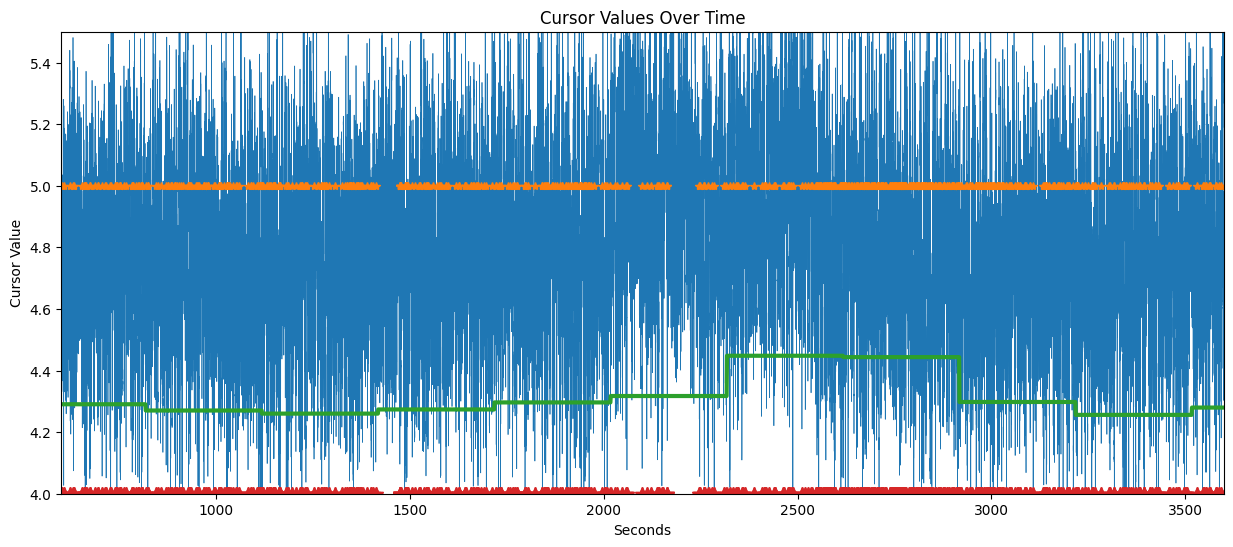

In [32]:
# Plot the cursor values
min = 600
max = 3600
plt.figure(figsize=(15, 6))
plt.plot(time_cursor, cursor, linewidth=0.5) 
plt.plot(time_bci_value, bci_value + 4, '*')
plt.plot(time_th_value, th_value, linewidth=3) 
# plt.plot(time_cursor_avg, cursor_avg, linewidth=2)
plt.plot(time_bci_value, rewarded_bci_value + 4, '*', markersize=10)

plt.title('Cursor Values Over Time')
plt.xlabel('Seconds')
plt.ylabel('Cursor Value')
# Set x-axis limits
plt.xlim(min, max)
plt.ylim(4, 5.5)

plt.show()

Heatmap con las ccs individuales en vez de la suma
Mirar otras sesiones
Mirar datos offline de ccs

In [9]:
min = 300
max = 3601
y_reference = np.linspace(np.cumsum(rewarded_bci_value).min(), np.cumsum(rewarded_bci_value).max(), len(rewarded_bci_value)-7500)
plt.plot(time_bci_value,np.cumsum(rewarded_bci_value))
plt.plot(time_bci_value[7500:], y_reference, '--')
plt.xlim(min, max)

# y_reference = np.linspace(np.cumsum(bci_value).min(), np.cumsum(bci_value).max(), len(bci_value)-7500)
# plt.plot(time_bci_value,np.cumsum(bci_value))
# plt.plot(time_bci_value[7500:], y_reference, '--')
# plt.xlim(min, max)

plt.title('Cumulative sum of rewards')
plt.xlabel('Seconds')
plt.ylabel('Time bins holded (40ms time bins)')

ValueError: Number of samples, -5942, must be non-negative.

Text(0, 0.5, 'Threshold crossings')

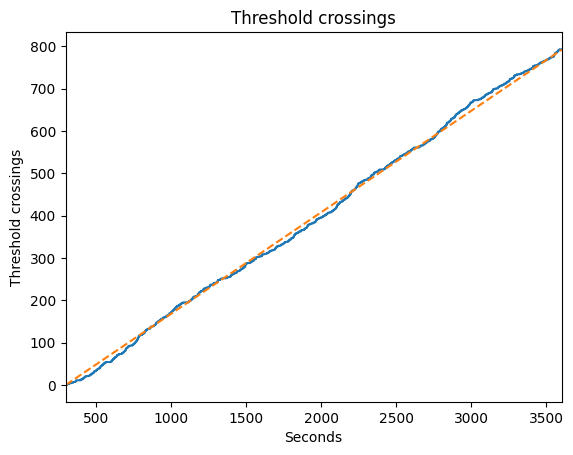

In [ ]:
min = 300
max = 3601

diff = np.diff(bci_value) > 0 # Changes from 0 to 1
y_reference = np.linspace(np.cumsum(diff).min(), np.cumsum(diff).max(), len(diff)-7500)

plt.plot(time_bci_value[:-1], np.cumsum(diff))
plt.plot(time_bci_value[7500:-1], y_reference, '--')
plt.xlim(min, max)
plt.title('Threshold crossings')
plt.xlabel('Seconds')
plt.ylabel('Threshold crossings')

Holding times!

Text(0, 0.5, 'Holding time in bins of 40ms')

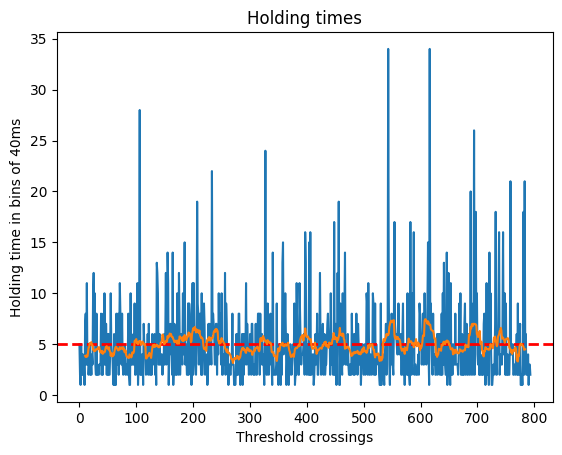

In [ ]:
# Find the start and end indices of groups of 1s
diff = np.diff(bci_value)
start_indices = np.where(diff == 1)[0] + 1
end_indices = np.where(diff == -1)[0] + 1

# Handle the case where the array starts or ends with a group of 1s
if bci_value[0] == 1:
    start_indices = np.insert(start_indices, 0, 0)
if bci_value[-1] == 1:
    end_indices = np.append(end_indices, len(bci_value))

# Calculate the number of 1s in each group
group_lengths = end_indices - start_indices


plt.plot(group_lengths)
plt.axhline(y=5, color='r', linestyle='--', linewidth=2)
window_size = 20
plt.plot(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size+1),np.convolve(group_lengths, np.ones(window_size)/window_size, mode='valid'))

plt.title('Holding times')
plt.xlabel('Threshold crossings')
plt.ylabel('Holding time in bins of 40ms')


In [ ]:
len(group_lengths)-window_size/2

784.0

In [ ]:
print(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size))

[ 10.          11.00129366  12.00258732  13.00388098  14.00517464
  15.00646831  16.00776197  17.00905563  18.01034929  19.01164295
  20.01293661  21.01423027  22.01552393  23.01681759  24.01811125
  25.01940492  26.02069858  27.02199224  28.0232859   29.02457956
  30.02587322  31.02716688  32.02846054  33.0297542   34.03104787
  35.03234153  36.03363519  37.03492885  38.03622251  39.03751617
  40.03880983  41.04010349  42.04139715  43.04269082  44.04398448
  45.04527814  46.0465718   47.04786546  48.04915912  49.05045278
  50.05174644  51.0530401   52.05433376  53.05562743  54.05692109
  55.05821475  56.05950841  57.06080207  58.06209573  59.06338939
  60.06468305  61.06597671  62.06727038  63.06856404  64.0698577
  65.07115136  66.07244502  67.07373868  68.07503234  69.076326
  70.07761966  71.07891332  72.08020699  73.08150065  74.08279431
  75.08408797  76.08538163  77.08667529  78.08796895  79.08926261
  80.09055627  81.09184994  82.0931436   83.09443726  84.09573092
  85.09702458

Compare first and second half of the recordings
